In [4]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import kagglehub

import tensorflow as tf
import keras
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras import backend as K
from keras.utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


In [6]:
# Construct the correct paths using os.path.join
folder_benign_train = os.path.join(path, 'train', 'benign')
folder_malignant_train = os.path.join(path, 'train', 'malignant')

folder_benign_test = os.path.join(path, 'test', 'benign')
folder_malignant_test = os.path.join(path, 'test', 'malignant')

In [7]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

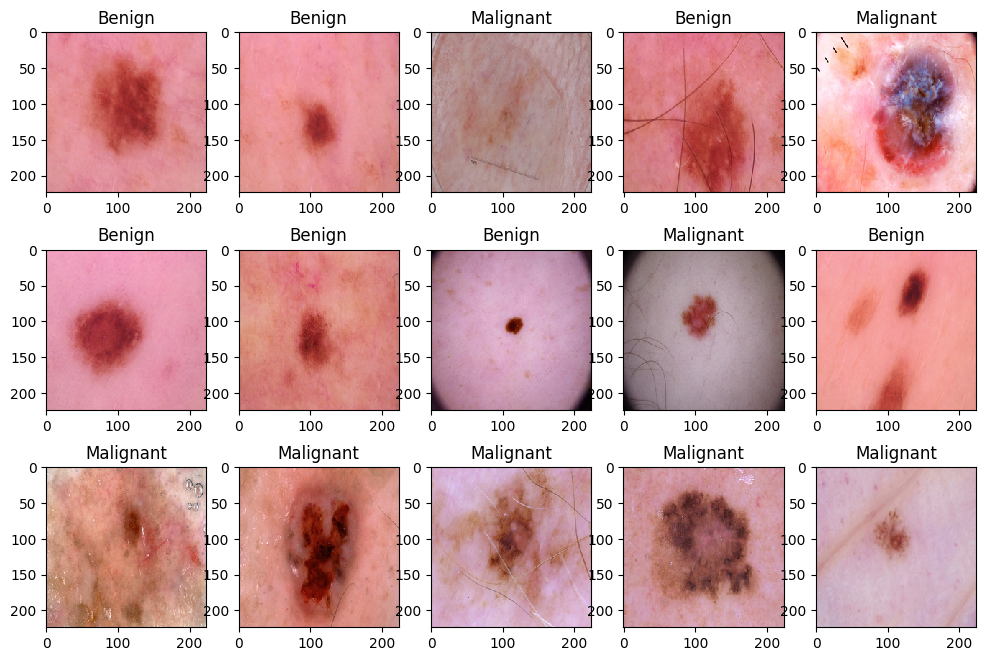

In [10]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

**Categorical Labels**

In [8]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

**Normalization**

In [9]:
# With data augmentation to prevent overfitting
X_train = X_train/255.
X_test = X_test/255.

# **Model Building**

**CNN**

In [13]:
def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = Adam(learning_rate=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


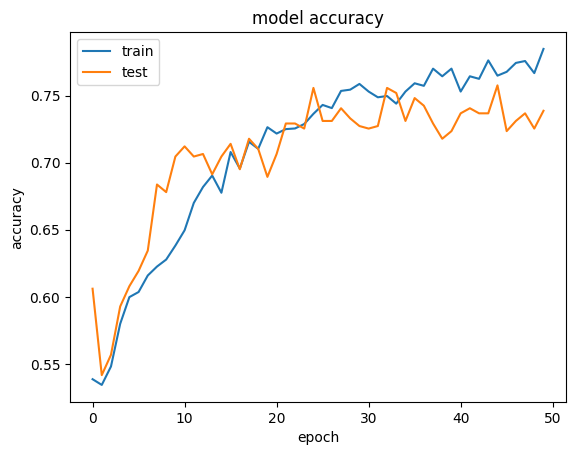

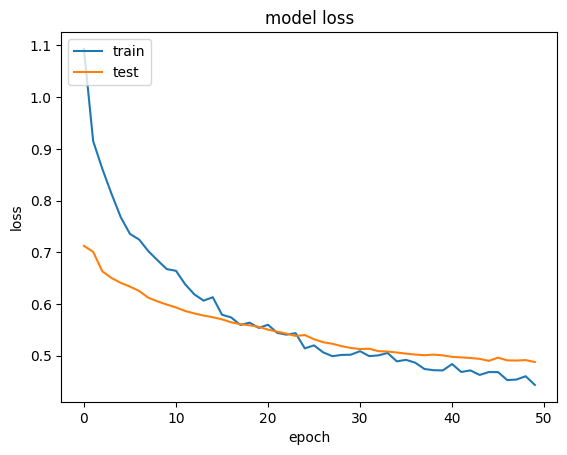

In [14]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 128

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0,
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
K.clear_session()
del model
del history

**Cross-Validating Model**

In [16]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = build(lr=lr,
                  init= init,
                  activ= activ,
                  optim=optim,
                  input_shape= input_shape)

    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 72.70%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 70.65%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

compile_metrics: 63.14%
68.83% (+/- 4.11%)


**Testing the model**

In [18]:
# Fitting model to all data
model = build(lr=lr,
              init= init,
              activ= activ,
              optim=optim,
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
         )

# Testing model on test data to evaluate
y_pred = np.argmax(model.predict(X_test), axis=-1)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,729,218 (98.15 MB)

 Trainable params: 25,729,218 (98.15 MB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
0.7606060606060606


In [20]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.weights.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model
K.clear_session()

Saved model to disk


# **ResNet50**

Epoch 1/50
33/33 - 127s - 4s/step - accuracy: 0.6330 - loss: 0.6366 - val_accuracy: 0.4640 - val_loss: 0.7040 - learning_rate: 1.0000e-05
Epoch 2/50
33/33 - 61s - 2s/step - accuracy: 0.7681 - loss: 0.4786 - val_accuracy: 0.4640 - val_loss: 0.7126 - learning_rate: 1.0000e-05
Epoch 3/50
33/33 - 21s - 636ms/step - accuracy: 0.7809 - loss: 0.4390 - val_accuracy: 0.5360 - val_loss: 0.7124 - learning_rate: 1.0000e-05
Epoch 4/50
33/33 - 20s - 618ms/step - accuracy: 0.8084 - loss: 0.3957 - val_accuracy: 0.5360 - val_loss: 0.7247 - learning_rate: 1.0000e-05
Epoch 5/50
33/33 - 22s - 669ms/step - accuracy: 0.8303 - loss: 0.3809 - val_accuracy: 0.5360 - val_loss: 0.7412 - learning_rate: 1.0000e-05
Epoch 6/50
33/33 - 20s - 595ms/step - accuracy: 0.8303 - loss: 0.3671 - val_accuracy: 0.5360 - val_loss: 0.8176 - learning_rate: 1.0000e-05
Epoch 7/50
33/33 - 21s - 624ms/step - accuracy: 0.8393 - loss: 0.3519 - val_accuracy: 0.5360 - val_loss: 0.8016 - learning_rate: 1.0000e-05
Epoch 8/50
33/33 - 20s - 

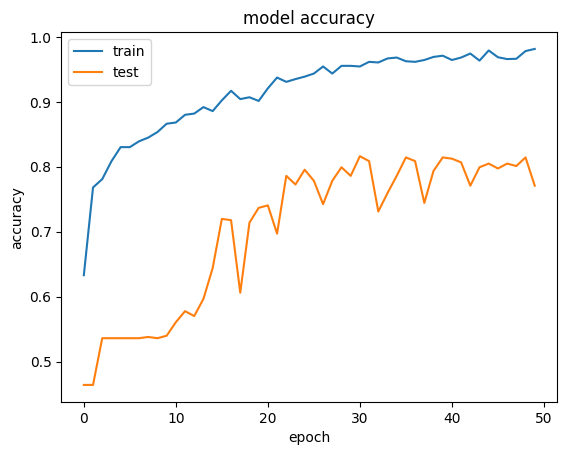

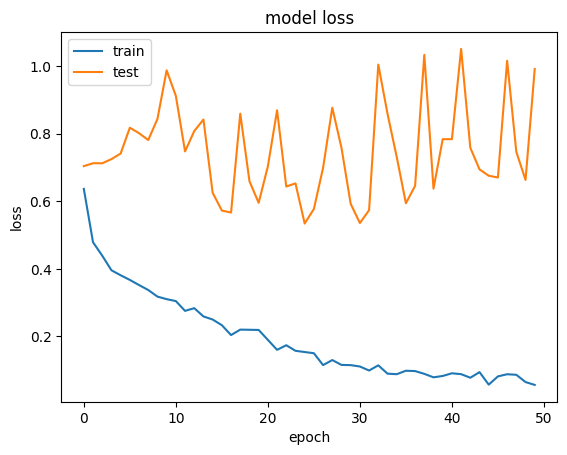

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy",
              metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2,
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )

In [14]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)

# serialize weights to HDF5
model.save_weights("resnet50.weights.h5")
print("Saved model to disk")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
0.8121212121212121
Saved model to disk


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       360
           1       0.84      0.72      0.78       300

    accuracy                           0.81       660
   macro avg       0.82      0.80      0.81       660
weighted avg       0.82      0.81      0.81       660



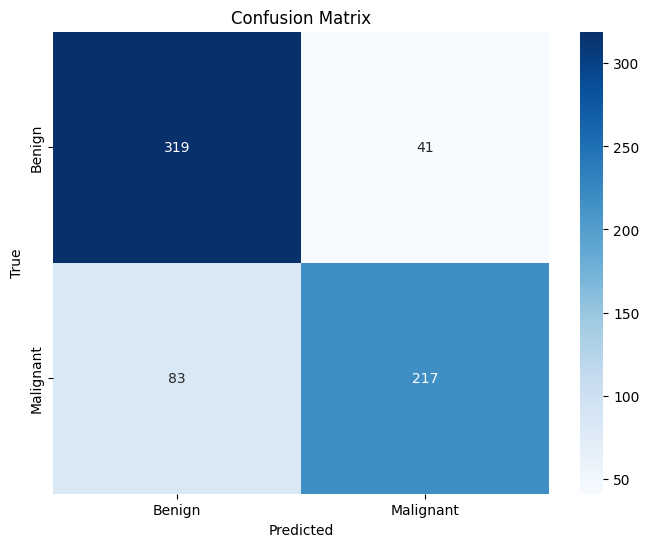

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()